## Indeed Analysis for Data Science Job Postings

#### Note: 
The below Jupyter Notebook has been implemented to review the functionality of Indeed scraping and analysis without AWS. The same code has been tweaked for AWS Implementation using Cloudwatch, Lambda and S3 Bucket (Please refer the 'Analysis on AWS' directory for the same)

The job posting data retrieved using web scraping is not an exact replica of the postings seen as per visual inspection online. This happens due to the dynamic content of the website being rendered by the browser differently by making future AJAX Calls. We could have mitigated this by using 'Selenium web driver' in addition to Beautiful Soup. However we chose to not use Selenium for the project since they are resource intensive and slower.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt

#### Extracting Job Title, Company Details, Location, Salary and Job Description for Analysis

In [2]:
def extract_job_title(soup, jobs, rows):
    for div in rows:
        for a in div.find_all(name='a', attrs={'data-tn-element': 'jobTitle'}):
            jobs.append(a['title'])
    return (jobs)

In [3]:
def extract_company(soup, companies, rows):
    for div in rows:
        company = div.find_all(name='span', attrs={'class': 'company'})
        if len(company) > 0:
            for b in company:
                companies.append(b.text.strip())
        else:
            sec_try = div.find_all(name='span', attrs={'class': 'result-link-source'})
            for span in sec_try:
                companies.append(span.text.strip())
    return (companies)

In [4]:
def extract_location(soup, locations, rows):
    for div in rows:
        try:
            location_div = div.find(name='div', attrs={'class': 'recJobLoc'})
            locations.append(location_div['data-rc-loc'])
        except:
            locations.append(np.nan)

    return (locations)

In [5]:
def extract_salary(soup, salaries, rows):
    for div in rows:
        try:
            salaries.append(div.find('nobr').text)
        except:
            try:
                div_two = div.find(name='div', attrs={'class': 'salarySnippet'})
                div_three = div_two.find('span')
                salaries.append(div_three.text.strip())
            except:
                salaries.append(np.nan)
    return (salaries)

In [6]:
def extract_description(soup, description, rows): 
  
    spans = soup.findAll('div', attrs={'class': 'summary'})
    for span in spans:
        description.append(span.text.strip())
    return(description)


#### Scraping the indeed data for the available Data Scientist positions and creating a dataframe for future analysis

In [7]:
def indeed_scrape():
    jobs = []
    companies = []
    locations = []
    salaries = []
    description=[]
    
    # Number of pages to be scraped = (100*10)+1 
    # where 100 is the actual number of pages scraped. 10 is the offset for each indeed page.
    max_results = 1001

    for start_val in range(0, max_results, 10):
        #url of indeed web page with job title filter set to data scientist.
        page = requests.get('https://www.indeed.com/jobs?q=Data+Scientist&start={}'.format(start_val))
        # ensuring at least 1 second between page extracts.
        time.sleep(1)  
        soup = BeautifulSoup(page.text, 'html.parser')
        #Extract div class which contains the information about a single job.
        rows = soup.find_all(name='div', attrs={'class': 'row'})
        job_title = extract_job_title(soup, jobs, rows)
        company_name = extract_company(soup, companies, rows)
        location = extract_location(soup, locations, rows)
        salaries = extract_salary(soup, salaries, rows)
        description= extract_description(soup,description,rows)
        #Create a dataframe from scraped data.
        indeed_df = pd.DataFrame(
        {'company_name': company_name, 'job_title': job_title, 'location': location, 'salaries': salaries,'description':description})
    return indeed_df

#### Preprocessing the data before analysis. The following operations were performed:
#### 1) Removing the duplicate entries of job postings. Here we have used combination of fields like location,job title, company name and description to be the unique identifier
#### 2) Creating a new column 'state' by extracting information from the location field
#### 3) Extracting the Minumum, Maximum and Mean Salary from the Salary range available in postings
#### 4) Check the salary unit (example: hourly salary/yearly) and convert the available salary to Yearly amount. 

In [8]:
def preprocess(indeed_data):
    
    indeed_data=indeed_data.drop_duplicates(subset =['location', 'job_title','company_name','description'], keep = 'last').reset_index()
    
    # Extract the state from location column.
    indeed_data['state'] = np.nan
    for i in range(len(indeed_data['state'])):
        try:
            indeed_data.loc[i, 'state'] = indeed_data.loc[i,'location'].split(',')[1]
        except:
            pass
            
    # Extract the available max and min salary boundaries for every job posting
    indeed_data['min_salary'] = indeed_data['salaries'].str.split('-').str[0].str.split().str[0].str[1:]
    indeed_data['max_salary'] = indeed_data['salaries'].str.split('-').str[1].str.split().str[0].str[1:]
    for i in range(len(indeed_data['min_salary'])):
        if indeed_data.loc[i,'min_salary'] is not np.NaN:
            indeed_data.loc[i,'min_salary'] = str(indeed_data.loc[i,'min_salary']).replace(',','')
            indeed_data.loc[i,'max_salary'] = str(indeed_data.loc[i,'max_salary']).replace(',','')
            
    # Check the salary unit (example: hourly salary/yearly) and convert the available salary to Yearly amount.        
    indeed_data['min_salary'] = indeed_data['min_salary'].str.replace('(Indeed est.)', '')
    indeed_data["Suffix"] = indeed_data["salaries"].str.split().str[-1]
    
    indeed_data['min_salary'] = indeed_data['min_salary'].astype('float')
    indeed_data['max_salary'] = indeed_data['max_salary'].astype('float')

    
    indeed_data['mean_salary'] = np.nan 
    for i in range(len(indeed_data['min_salary'])):
        if(indeed_data.loc[i,'Suffix'] == 'hour'):
            #Consider full time employee with 40hours/ week , 1 year = 52.1429 weeks.
            indeed_data.loc[i,'min_salary'] = indeed_data.loc[i,'min_salary']*40*52.1429
            indeed_data.loc[i,'max_salary'] = indeed_data.loc[i,'max_salary']*40*52.1429
        
        # Calculate mean salary from minimum and maximum salary
        if pd.isnull(indeed_data['min_salary'][i]):
            indeed_data.loc[i,'mean_salary'] = indeed_data['max_salary'][i]
        elif pd.isnull(indeed_data['max_salary'][i]):
            indeed_data.loc[i,'mean_salary'] = indeed_data['min_salary'][i]
        else:
            indeed_data.loc[i,'mean_salary'] = (indeed_data['min_salary'][i]+indeed_data['max_salary'][i])/2
            
    indeed_data = extract_specialization(indeed_data)    
    return indeed_data

#### Categorizing job titles into Data science specializations like NLP, ML, Biomedical, Junior /Senior /Intern positions based on the available Job Titles in the indeed post

In [9]:
def extract_specialization(job_data):
    job_data.loc[:,'Job_Title_Category'] = np.nan
    job_data.loc[:,'job_title'] = job_data.loc[:,'job_title'].str.lower()
   
    job_data.loc[job_data['job_title'].str.contains(
            'data scientist|data science|data science & insights|data science and insights|scientist'), 'Job_Title_Category'] = 'Data Scientist'
    job_data.loc[job_data['job_title'].str.contains(
            'analyst|analytics|analysis'), 'Job_Title_Category'] = 'Data Analyst'
    job_data.loc[job_data['job_title'].str.contains(
            'intern|internship|university|graduate|coop|student|co-op'),'Job_Title_Category'] = 'Data Science Intern/ University Graduate'
    job_data.loc[job_data['job_title'].str.contains(
            'jr|junior|entry level|early career'), 'Job_Title_Category'] = 'Junior Data Scientist'
    job_data.loc[job_data['job_title'].str.contains(
            'sr|senior|phd|research'), 'Job_Title_Category'] = 'Senior Data Scientist'
    job_data.loc[job_data['job_title'].str.contains(
            'machine learning|machine_learning|deep|ai|artificial intelligence'), 'Job_Title_Category'] = 'Machine Learning/ AI/ Deep Learning'
    job_data.loc[job_data['job_title'].str.contains(
            'health|biomedical|bio|bioengineer|bioinformatics|neuro'), 'Job_Title_Category'] = 'Health/ Biomedical Data Science'
    job_data.loc[job_data['job_title'].str.contains(
            'nlp|language'), 'Job_Title_Category'] = 'Natural Language Processing'
    job_data.loc[job_data['job_title'].str.contains(
            'market|quantitative|digital marketing|search|supply chain|payment|advertising'), 'Job_Title_Category'] = 'Data Science-Marketing'
    job_data.loc[job_data['Job_Title_Category'].isnull(),'Job_Title_Category'] = 'Others'
    return job_data

#### Formatting the plots used for analysis

In [10]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,8)})

#### Plotting the distribution of average salaries for data science postions across different states in the United States using Boxplot

In [11]:
def plot_mean_salary_per_state(indeed_data):
    indeed_data = indeed_data[['mean_salary','state']].dropna()
    sns.boxplot(x="state", y="mean_salary", data=indeed_data)
    plt.xlabel("States")
    plt.ylabel("Mean Salary")    
    plt.title("Mean Salary per State");

#### Creating a two dimensional summary of data using heatmap. 
#### This plot represents the number of job postings against different "data science specializations" for different states. 
#### We are representing on top 15 states in the graph for which the highest number of job postings are available

In [12]:
def plot_designation_cnt(indeed_data):
    df = indeed_data.groupby('state').count().sort_values(['Job_Title_Category'],ascending=False).head(15).reset_index()['state']
    jobs_top_state = indeed_data[indeed_data['state'].isin(df)]
    job_category = extract_specialization(jobs_top_state)
    job_category = pd.crosstab(job_category.state,job_category.Job_Title_Category)
    sns.heatmap(job_category, annot=True, fmt="d")
    plt.title("Job Openings per State");
    plt.xlabel("Job Specialization")
    plt.ylabel("States")    
    

#### Creating a bar graph to represent the number of job postings available per state

In [13]:
def plot_no_of_jobs_per_state(jobs_data):
    no_of_jobs =jobs_data.groupby(['state']).count().reset_index().sort_values(['company_name'],ascending=False).head(15)
    sns.barplot(x="state", y="company_name", data=no_of_jobs)
    plt.xlabel("States")
    plt.ylabel("Number of job postings")
    plt.title("Number of Data Science Jobs per state")

#### Representing the association between 'Job Specialization' and 'Salary' across different states using a scatterplot

In [14]:
def plot_salary_per_specialization(data_preprocessed):
    sns.scatterplot(x='state', y = 'mean_salary',hue='Job_Title_Category', data=data_preprocessed)
    plt.xlabel("States")
    plt.ylabel("Mean Salary")
    plt.title("Salary distribution per specialization for each state")

In [20]:
if __name__ == '__main__':
    data = indeed_scrape()
    display(data.head(10))
    
    data_preprocessed = preprocess(data)
    display(data_preprocessed.head(10))

,company_name,job_title,location,salaries,description
0,Indeed Prime,Data Scientist,"Atlanta, GA","$80,000 - $130,000 a year",Data Scientist requirements. 4+ years of exper...
1,Urner Barry,Junior Data Scientist,"Toms River, NJ",NaN,Data mining using state-of-the-art methods. En...
2,Signature Travel Network,"Cruise, Hotel Partnerships, Data Analysis","El Segundo, CA",NaN,Devise methods for identifying data patterns a...
3,Central Intelligence Agency,Data Scientist,"Washington, DC","$67,968 - $126,062 a year",Data Scientists clearly communicate their conc...
4,Valassis Digital,Staff Data Scientist,"Morrisville, NC",NaN,Staff Data Scientist – Machine Learning & Real...
5,"K2 Insurance Services, LLC",Data Scientist,"San Diego, CA",NaN,"Ideally, the Data Scientist will have:. Extens..."
6,Kajabi.com,Data Scientist - Analytics Awesomeness - We Wa...,"Irvine, CA",NaN,Responsibilities for Data Scientist*. We are l...
7,Verizon,Data Scientist,"Ashburn, VA",NaN,Knowledge of predictive and prescriptive analy...
8,Carpe Data,Data Scientist,"Santa Barbara, CA",NaN,Mentor junior data scientists. You will be rep...
9,University of California San Francisco,Data Scientist,"San Francisco, CA",NaN,The Arnaout laboratory studies deep and machin...


,index,company_name,job_title,location,salaries,description,state,min_salary,max_salary,Suffix,mean_salary,Job_Title_Category
0,8,Carpe Data,data scientist,"Santa Barbara, CA",NaN,Mentor junior data scientists. You will be rep...,CA,NaN,NaN,NaN,NaN,Data Scientist
1,9,University of California San Francisco,data scientist,"San Francisco, CA",NaN,The Arnaout laboratory studies deep and machin...,CA,NaN,NaN,NaN,NaN,Data Scientist
2,11,Vans,vans associate data scientist,"Costa Mesa, CA",NaN,Your attention to details and strong analytica...,CA,NaN,NaN,NaN,NaN,Data Scientist
3,12,"Appfigures, Inc.",data scientist intern,"New York, NY",NaN,You'll be working with our data science team t...,NY,NaN,NaN,NaN,NaN,Data Science Intern/ University Graduate
4,14,Visa,data scientist,"Foster City, CA",NaN,To support our rapidly growing group we are lo...,CA,NaN,NaN,NaN,NaN,Data Scientist
5,15,VF Corporation,vans associate data scientist,"Costa Mesa, CA",NaN,Your attention to details and strong analytica...,CA,NaN,NaN,NaN,NaN,Data Scientist
6,16,ExxonMobil,data scientist,"Houston, TX",NaN,Data science encompasses the computational and...,TX,NaN,NaN,NaN,NaN,Data Scientist
7,17,Decision Sciences,data scientist,"Poway, CA",NaN,Data mining using state-of-the-art methods. To...,CA,NaN,NaN,NaN,NaN,Data Scientist
8,26,Direct-to-Consumer and International,data scientist,"Burbank, CA",NaN,"Development of prototype solutions, mathematic...",CA,NaN,NaN,NaN,NaN,Data Scientist
9,27,Uber,data scientist - fares,"San Francisco, CA",NaN,"Use your quantitative skill set, obsession and...",CA,NaN,NaN,NaN,NaN,Data Scientist


#### Plot Results:
Note: The below analysis was performed based on the observations on 16th May (Values can changes with time based on the new job openings on Indeed)

### 1) Number of jobs per State:
#### The below graph represents the number of job postings of top 15 states. 
#### It can be observed that California has the highest number of job postings available for data science postions, followed by New York.
#### The count of data science jobs are on the lower side for states like Utah, Arizona
#### States like Rhode Island, Albama, etc are not part of the plot below, since these states have very less number of postings available on indeed (as compared to the top 15 states below)

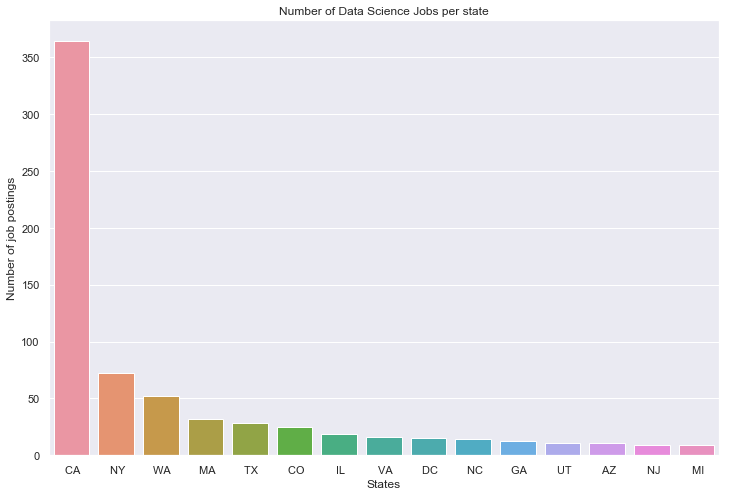

In [16]:
plot_no_of_jobs_per_state(data_preprocessed)

### 2) Salary range per State:

#### It can be observed in the below graph that the median salary is highest for California, followed by New York and Texas. 

#### States like Oregon, Tennessee, Iowa have a low median salary for the data science positions.

#### It can also be observed that many states do not have variation in the salary range. This could be possible because of less job opportunities available in those states, or lack of salary information in the indeed job postings.

#### California has some large outliers in the minimum and maximum salary range.

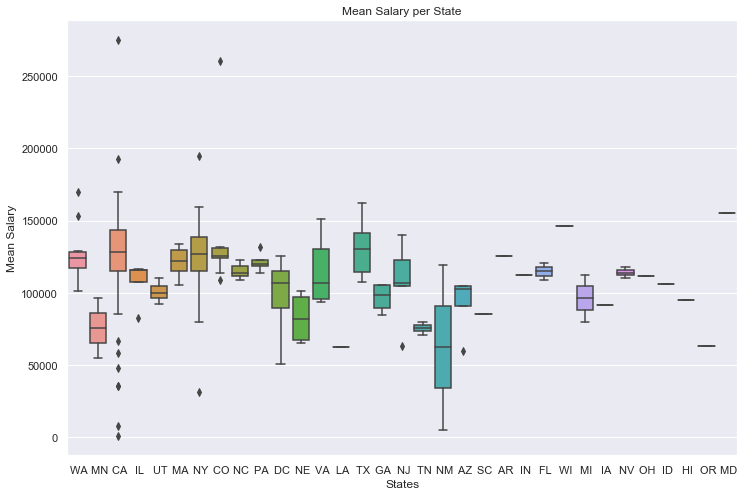

In [17]:
plot_mean_salary_per_state(data_preprocessed)

### 3) Job Specialization count per state

#### It can be observed that most of the job postings fall under the generic "Data Sciencist" category without any demand of specializations. This is followed by Machine Learning, Data Science-Marketing and Data Analyst jobs
#### There are more of Senior Data Scientist positions available in the market as compared to Intern, University Graduate and Junior data scientist postions.
#### Due to the high number of jobs available, the count values displayed in the heatmap below are higher for CA and NY against different Job Title categories

c:\users\rashm\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


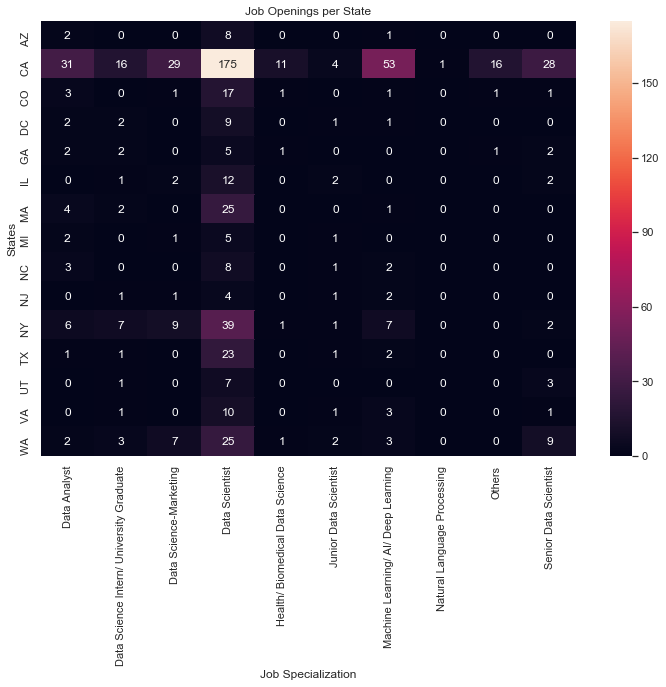

In [18]:
plot_designation_cnt(data_preprocessed)

### 3) Salary per job specialization:
#### As expected, the salary for Interns, Junior Data scientists are very less compared to the Experienced counterparts.
#### Some data scientists and Machine learning experts earn a lot more than the median salary range. California offers a wide range of salary for different positions. This could definitely be possible because CA has a wide mixture of tech giants, mid size and start up companies in the Bay area.
#### There is not much difference in the median salary of the generic data scientist and data analyst positions.

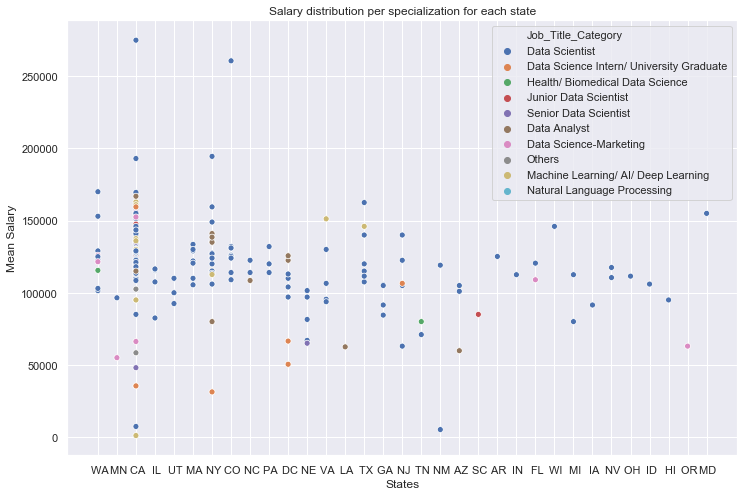

In [19]:
plot_salary_per_specialization(data_preprocessed)